In [5]:
import os
import json
path_to_json=os.path.join(os.getcwd(), "json_files")
os.listdir(path_to_json)
import os, json
import pandas as pd, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
#from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier

##using code from PAUSE_PREDICt.ipynb for preprocessing
null = None
false = False
true = True
NoneType = None

new_dict = {}
new_dict["pause_duration"] = []
new_dict["no_of_pauses"] = []
new_dict["uh_duration"] = []
new_dict["no_of_uh"] = []
new_dict["um_duration"] = []
new_dict["no_of_um"] = []
new_dict["binary_classifier"] = []

pause_duration = []
pause_per_sec = []
setter = set()
inter = set()

filled_ted = 0
filled_audio = 0
print("Preprocessing external data...")
# we need both the json and an index number so use enumerate()
for subdir, dirs, files in os.walk(path_to_json):
      for file in files:
        if file.endswith(".json"):
            path = os.path.join(subdir, file)
            
            with open(path) as f:
                json_text = json.loads(f.read())
                #json_text = json.loads(f)
                
            json_text = eval(json_text)
            score = json_text["Score"]
            json_text = json_text["AnalysisResult"]
            
            #id_ = json_text["id"]
            feature_dict = {}

            if score < 5:
                print("OUTLIER DETECTED")
                continue
                
            elapsed_time = json_text["performance"]["elapsed_time"]
            counter_pauses = 0
            counter_uh = 0
            counter_um = 0
            timer_pauses = 0
            timer_uh = 0
            timer_um = 0
            
            for tok in json_text["tokens"]:
                Text = tok["text"].lower()
                if (Text == "sil"):
                    pause_time = tok["end_time"] - tok["start_time"]
                    timer_pauses += pause_time
                    counter_pauses += 1
                elif (Text == "uh"):
                    uh_time = tok["end_time"] - tok["start_time"]
                    timer_uh += uh_time
                    counter_uh += 1
                    if "TED" in file:
                        filled_ted += 1
                    else: filled_audio += 1
                elif (Text == "um"):
                    um_time = tok["end_time"] - tok["start_time"]
                    timer_um += um_time
                    counter_um += 1
                    if "TED" in file:
                        filled_ted += 1
                    else: filled_audio += 1
                    
            new_dict["pause_duration"].append(timer_pauses/elapsed_time)
            new_dict["no_of_pauses"].append(counter_pauses/elapsed_time)

                
            new_dict["uh_duration"].append(timer_uh/elapsed_time)
            new_dict["no_of_uh"].append(counter_uh/elapsed_time)


            new_dict["um_duration"].append(timer_um/elapsed_time)
            new_dict["no_of_um"].append(counter_um/elapsed_time)
    
    
        # adding Read and Spontaneous label
        if "TED" in file:
            binary = 1
        else:
            binary = 0
        new_dict["binary_classifier"].append(binary)
            
print(sum(new_dict["binary_classifier"]))

print("create dataframe from dictionary")
df = pd.DataFrame.from_dict(new_dict)

print("Normalizing data")
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != "binary_classifier":
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            if max_value * min_value != 0:
                result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
            else: result[feature_name] = df[feature_name]
    return result

df = normalize(df)
### all above was code copied from Pauses_prediction.ipynb


df.head()


Preprocessing external data...
OUTLIER DETECTED
OUTLIER DETECTED
OUTLIER DETECTED
OUTLIER DETECTED
OUTLIER DETECTED
OUTLIER DETECTED
OUTLIER DETECTED
OUTLIER DETECTED
OUTLIER DETECTED
OUTLIER DETECTED
418
create dataframe from dictionary
Normalizing data


,pause_duration,no_of_pauses,uh_duration,no_of_uh,um_duration,no_of_um,binary_classifier
0,0.144782,0.380138,0.000000,0.000000,0.000000,0.000000,0
1,0.139297,0.315287,0.000000,0.000000,0.000000,0.000000,0
2,0.276166,0.634876,0.000000,0.000000,0.000000,0.000000,0
3,0.229452,0.363800,0.017212,0.023659,0.012244,0.017744,1
4,0.149581,0.498824,0.008688,0.022277,0.000000,0.000000,1


In [13]:
from sklearn.decomposition import PCA
required_columns=list(df.columns[:-1])
print (required_columns)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df[required_columns])
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

['pause_duration', 'no_of_pauses', 'uh_duration', 'no_of_uh', 'um_duration', 'no_of_um']


In [20]:
finalDf = pd.concat([principalDf, df[['binary_classifier']]], axis = 1)
def numbertolabel(x):
    if x==1:
        return "PLANNED"
    return "READ"
finalDf['binary_classifier']=finalDf['binary_classifier'].apply(numbertolabel)

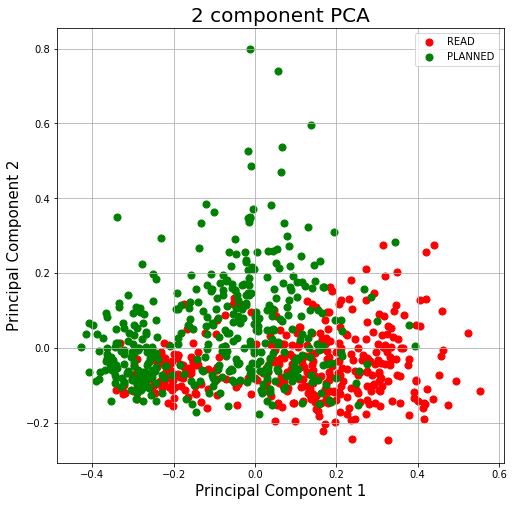

In [23]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['READ','PLANNED']
colors=['r','g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['binary_classifier'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


## For Gweek Data

In [28]:
labelled_gweek_data=pd.read_csv("labelled_data.csv")
####CODE COPIED FROM PAUSE_PREDICT.ipynb  CODE for checking the gweek daa
########


# Get feature representation of test data(gweek data)

#path_to_json = 'JSON'
path_to_json = '../data_folder/json_train'
path_to_json=os.path.join(os.getcwd(),'json_train')

new_dict = {}
new_dict["id"] = []
new_dict["pause_duration"] = []
new_dict["no_of_pauses"] = []
new_dict["uh_duration"] = []
new_dict["no_of_uh"] = []
new_dict["um_duration"] = []
new_dict["no_of_um"] = []

pause_duration = []
pause_per_sec = []
setter = set()
inter = set()

filled_ted = 0
filled_audio = 0

id_list = []
for subdir, dirs, files in os.walk(path_to_json):
    for file in files:
        if file.endswith(".json"):
            path = os.path.join(subdir, file)

            with open(path, 'r') as f:
                json_text = json.load(f)
            id_ = file
            
            feature_dict = {}

            score = json_text["score"]
            
            if id_ in id_list:
                continue
            
            id_list.append(id_)

            if score < 5:
                print("OUTLIER")
                continue
                
            if not json_text["tokens"]:
                print("Outlier, no tokens")
                continue
            
            new_dict["id"].append(id_)
            

            elapsed_time = json_text["elapsed_time"]
            counter_pauses = 0
            counter_uh = 0
            counter_um = 0
            timer_pauses = 0
            timer_uh = 0
            timer_um = 0
            
            for tok in json_text["tokens"]:
                Text = tok["text"].lower()
                if (Text == "sil"):
                    pause_time = tok["end_time"] - tok["start_time"]
                    timer_pauses += pause_time
                    counter_pauses += 1
                elif (Text == "uh"):
                    uh_time = tok["end_time"] - tok["start_time"]
                    timer_uh += uh_time
                    counter_uh += 1
                    if "TED" in file:
                        filled_ted += 1
                    else: filled_audio += 1
                elif (Text == "um"):
                    um_time = tok["end_time"] - tok["start_time"]
                    timer_um += um_time
                    counter_um += 1
                    if "TED" in file:
                        filled_ted += 1
                    else: filled_audio += 1
                    
            new_dict["pause_duration"].append(timer_pauses/elapsed_time)
            new_dict["no_of_pauses"].append(counter_pauses/elapsed_time)

                
            new_dict["uh_duration"].append(timer_uh/elapsed_time)
            new_dict["no_of_uh"].append(counter_uh/elapsed_time)


            new_dict["um_duration"].append(timer_um/elapsed_time)
            new_dict["no_of_um"].append(counter_um/elapsed_time)
    
    
print(len(new_dict["id"]),"Gweek files getting checked")
print("create dataframe from dictionary")
df = pd.DataFrame.from_dict(new_dict)

print("Normalizing data")
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != "id":
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            if max_value * min_value != 0:
                result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
            else: result[feature_name] = df[feature_name]
    return result

df = normalize(df)

print("Preprocessing done")






Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
OUTLIER
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
Outlier, no tokens
3230 Gweek files getting checked
create dataframe from dictionary
Normalizing data
Preprocessing done


In [52]:
a=labelled_gweek_data[labelled_gweek_data['ID']=='3cb16854-e271-41e3-8f2a-214e15039d37_f16957b8-8125-49d5-abd0-3f8ee5d341b3.json']

In [56]:
a['LABEL'].values[0]

'planned'

In [57]:
def check_for_label(gid):
    the_frame=labelled_gweek_data[labelled_gweek_data['ID']==gid]
    if len(the_frame)==0:
        return 'NOTHING'
    return the_frame['LABEL'].values[0]
    
df['TARGET']=df['id'].apply(check_for_label)

In [66]:
from sklearn.decomposition import PCA
required_columns=list(df.columns[1:-1])
print (required_columns)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df[required_columns])
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[['TARGET']]], axis = 1)


['pause_duration', 'no_of_pauses', 'uh_duration', 'no_of_uh', 'um_duration', 'no_of_um']


## PCA FOR THE GWEEK DATa

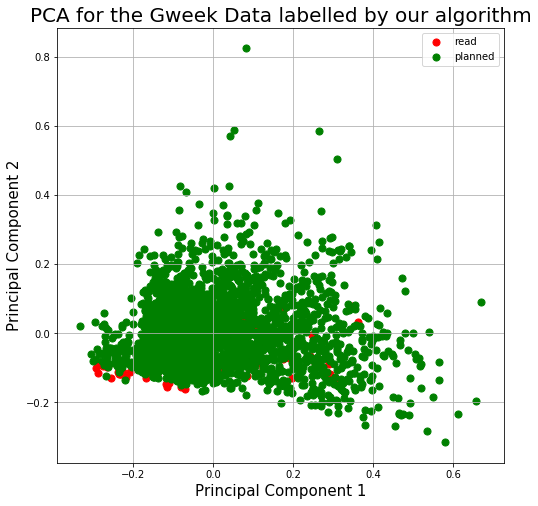

In [68]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA for the Gweek Data labelled by our algorithm', fontsize = 20)
targets = ['read','planned']
colors=['r','g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['TARGET'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
